Purpose of EDA in this case.
- look for obvious correlations
- look for biases in dataset, over/under representation, skews between groupings
- where biases are found attempt to asses if they are likely to be due to sampling or are they a real population.


import potentially helpful modules and libraries 
may not use them all

In [6]:
import re
import numpy as np
import seaborn as sns
import os
import pandas as pd
import sklearn as sk
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

find the files and check the directory, if all good then load the data

In [7]:
print(os.listdir(), '\n', os.getcwd())

with open('plot_time.csv', 'r') as init_data:
    raw_data = pd.read_csv(init_data)

['.git', '.gitattributes', '.ipynb_checkpoints', 'big_MCI_plot.png', 'data_analysis_script.py', 'DX_bl_big_MCI_plot.png', 'EDA.ipynb', 'plot_time.csv', 'prelim data analysis.py', 'PTGENDER_big_MCI_plot.png', 'simple_data.csv', 'TADPOLE_D1_D2.csv', 'TADPOLE_D1_D2.py', 'TADPOLE_D1_D2_Dict.csv', 'TADPOLE_D2.m', 'TADPOLE_D3.csv', 'TADPOLE_D3.m', 'TADPOLE_readme.txt'] 
 C:\Users\work_cbdvl\Documents\GitHub\Project-daybreak


['CN' 'AD' 'LMCI' 'EMCI' 'SMC']
['NL' nan 'NL to MCI' 'Dementia' 'MCI' 'MCI to Dementia' 'MCI to NL'
 'Dementia to MCI' 'NL to Dementia']
[ 1. nan  4.  3.  2.  5.  7.  8.  6.]


build 2 additional binary catagorical columns: is the patient impaired at any point in the study , imparied or normal (1,0) and is there ever a change in diagnosis for this patient (change = 1)

In [61]:
patients = raw_data.loc[:,"RID"].unique()

changers = np.zeros(len(patients))
impaired = np.zeros(len(patients))

cata = pd.DataFrame(patients)
cata["change"] = changers
cata["impaired"] = impaired
cata.rename(columns={0:"rid"}, inplace=True)

for i,v in enumerate(cata.loc[:,"rid"]):
    vals = raw_data.loc[raw_data["RID"] == v, ["DX_bl", "DXCHANGE"]]
    if sum(vals.DXCHANGE > 3) > 0:
        cata.loc[i, "change"] = 1
    if ((vals.DX_bl.any() != "CN") | sum(vals.DXCHANGE > 1) > 0):
        cata.loc[i, "impaired"] = 1      
        

In [ ]:
look up joining the dataframes

In [62]:
raw_data["change"] = np.zeros(len(raw_data))
raw_data["impaired"] = np.zeros(len(raw_data))
for i in patients:
    raw_data.loc[raw_data["RID"] == i, "change"] = cata.loc[cata["rid"] == i, "change"].mean()
    raw_data.loc[raw_data["RID"] == i, "impaired"] = cata.loc[cata["rid"] == i, "impaired"].mean()
raw_data.describe()

,Unnamed: 0,RID,AGE,PTEDUCAT,APOE4,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,...,Entorhinal,MidTemp,FDG,AV45,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,VISNUMS,change,impaired
count,12741.000000,12741.000000,12741.000000,12741.000000,12729.000000,12741.000000,12724.000000,12663.000000,12741.000000,12705.000000,...,6469.000000,6469.000000,3352.000000,2118.000000,2371.000000,2371.000000,2370.000000,12741.000000,12741.000000,12741.000000
mean,6370.000000,2240.325720,73.814865,15.988384,0.537277,1.355820,9.814569,15.505631,27.566910,36.452499,...,3444.718813,19203.260318,1.208239,1.194780,1023.744285,293.062876,28.068156,25.859901,0.351071,0.783063
std,3678.154225,1855.269911,6.973068,2.829707,0.655835,1.554823,5.908569,8.713772,2.394201,12.046854,...,811.771966,3138.155124,0.160831,0.227518,597.445735,132.260409,14.569570,25.945824,0.477324,0.412176
min,0.000000,2.000000,54.400000,4.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,...,1041.000000,8044.000000,0.636804,0.835796,100.000000,40.000000,4.000000,0.000000,0.000000,0.000000
25%,3185.000000,618.000000,69.600000,14.000000,0.000000,0.000000,5.670000,9.000000,26.000000,28.000000,...,2905.000000,17183.000000,1.109723,1.010035,572.150000,202.600000,17.797500,6.000000,0.000000,1.000000
50%,6370.000000,1280.000000,73.800000,16.000000,0.000000,1.000000,8.670000,14.000000,28.000000,35.000000,...,3482.000000,19240.000000,1.219805,1.113975,832.000000,264.400000,24.470000,18.000000,0.000000,1.000000
75%,9555.000000,4328.000000,78.700000,18.000000,1.000000,2.000000,13.000000,20.330000,29.000000,45.000000,...,4013.000000,21397.000000,1.314253,1.362275,1375.500000,356.500000,34.397500,36.000000,1.000000,1.000000
max,12740.000000,5296.000000,91.400000,20.000000,2.000000,10.000000,42.670000,54.670000,30.000000,71.000000,...,6711.000000,32189.000000,1.753320,2.669210,3592.000000,1500.000000,150.000000,120.000000,1.000000,1.000000


In [63]:
print("So there are", len(patients), "patients and 12741 data points.")
print("Of those patients", cata.change.sum(), " change in diagnosis and", len(patients) - cata.impaired.sum(), "patients remain cognitively normal throughout.")

So there are 1737 patients and 12741 data points.
Of those patients 474.0  change in diagnosis and 330.0 patients remain cognitively normal throughout.


In [64]:
raw_data.describe()

,Unnamed: 0,RID,AGE,PTEDUCAT,APOE4,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,...,Entorhinal,MidTemp,FDG,AV45,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,VISNUMS,change,impaired
count,12741.000000,12741.000000,12741.000000,12741.000000,12729.000000,12741.000000,12724.000000,12663.000000,12741.000000,12705.000000,...,6469.000000,6469.000000,3352.000000,2118.000000,2371.000000,2371.000000,2370.000000,12741.000000,12741.000000,12741.000000
mean,6370.000000,2240.325720,73.814865,15.988384,0.537277,1.355820,9.814569,15.505631,27.566910,36.452499,...,3444.718813,19203.260318,1.208239,1.194780,1023.744285,293.062876,28.068156,25.859901,0.351071,0.783063
std,3678.154225,1855.269911,6.973068,2.829707,0.655835,1.554823,5.908569,8.713772,2.394201,12.046854,...,811.771966,3138.155124,0.160831,0.227518,597.445735,132.260409,14.569570,25.945824,0.477324,0.412176
min,0.000000,2.000000,54.400000,4.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,...,1041.000000,8044.000000,0.636804,0.835796,100.000000,40.000000,4.000000,0.000000,0.000000,0.000000
25%,3185.000000,618.000000,69.600000,14.000000,0.000000,0.000000,5.670000,9.000000,26.000000,28.000000,...,2905.000000,17183.000000,1.109723,1.010035,572.150000,202.600000,17.797500,6.000000,0.000000,1.000000
50%,6370.000000,1280.000000,73.800000,16.000000,0.000000,1.000000,8.670000,14.000000,28.000000,35.000000,...,3482.000000,19240.000000,1.219805,1.113975,832.000000,264.400000,24.470000,18.000000,0.000000,1.000000
75%,9555.000000,4328.000000,78.700000,18.000000,1.000000,2.000000,13.000000,20.330000,29.000000,45.000000,...,4013.000000,21397.000000,1.314253,1.362275,1375.500000,356.500000,34.397500,36.000000,1.000000,1.000000
max,12740.000000,5296.000000,91.400000,20.000000,2.000000,10.000000,42.670000,54.670000,30.000000,71.000000,...,6711.000000,32189.000000,1.753320,2.669210,3592.000000,1500.000000,150.000000,120.000000,1.000000,1.000000


In [65]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12741 entries, 0 to 12740
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  12741 non-null  int64  
 1   RID                         12741 non-null  int64  
 2   EXAMDATE                    12741 non-null  object 
 3   DX_bl                       12741 non-null  object 
 4   AGE                         12741 non-null  float64
 5   PTGENDER                    12741 non-null  object 
 6   PTEDUCAT                    12741 non-null  int64  
 7   PTETHCAT                    12741 non-null  object 
 8   PTRACCAT                    12741 non-null  object 
 9   PTMARRY                     12741 non-null  object 
 10  APOE4                       12729 non-null  float64
 11  EXAMDATE_bl                 12741 non-null  object 
 12  CDRSB_bl                    12741 non-null  float64
 13  ADAS11_bl                   127

In [49]:
for c,v in enumerate(raw_data.columns):
    print(c, v )

0 Unnamed: 0
1 RID
2 EXAMDATE
3 DX_bl
4 AGE
5 PTGENDER
6 PTEDUCAT
7 PTETHCAT
8 PTRACCAT
9 PTMARRY
10 APOE4
11 EXAMDATE_bl
12 CDRSB_bl
13 ADAS11_bl
14 ADAS13_bl
15 MMSE_bl
16 RAVLT_immediate_bl
17 RAVLT_learning_bl
18 RAVLT_forgetting_bl
19 RAVLT_perc_forgetting_bl
20 FAQ_bl
21 Ventricles_bl
22 Hippocampus_bl
23 WholeBrain_bl
24 Entorhinal_bl
25 Fusiform_bl
26 MidTemp_bl
27 ICV_bl
28 Years_bl
29 Month_bl
30 Month
31 M
32 DX
33 DXCHANGE
34 CDRSB
35 MMSE
36 RAVLT_immediate
37 Hippocampus
38 WholeBrain
39 Entorhinal
40 MidTemp
41 FDG
42 AV45
43 ABETA_UPENNBIOMK9_04_19_17
44 TAU_UPENNBIOMK9_04_19_17
45 PTAU_UPENNBIOMK9_04_19_17
46 VISNUMS
47 change
48 impaired


In [53]:
plot_col = [4,5,6,7,8,9,2, 41, 42, 24, 39, 47, 48]
# [4,5,6,7,8,9,22,37,43, 3,32,33, 44, 45, 38, 10, 12, 34, 41, 42, 24, 39, 47, 48]
plot_col.sort()
print(plot_col)

[2, 4, 5, 6, 7, 8, 9, 24, 39, 41, 42, 47, 48]


is there a connection between gender and cognitive degeneration?

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:125: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernels.py:125: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1520: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\contour.py:1521: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib

Male      7217
Female    5524
Name: PTGENDER, dtype: int64


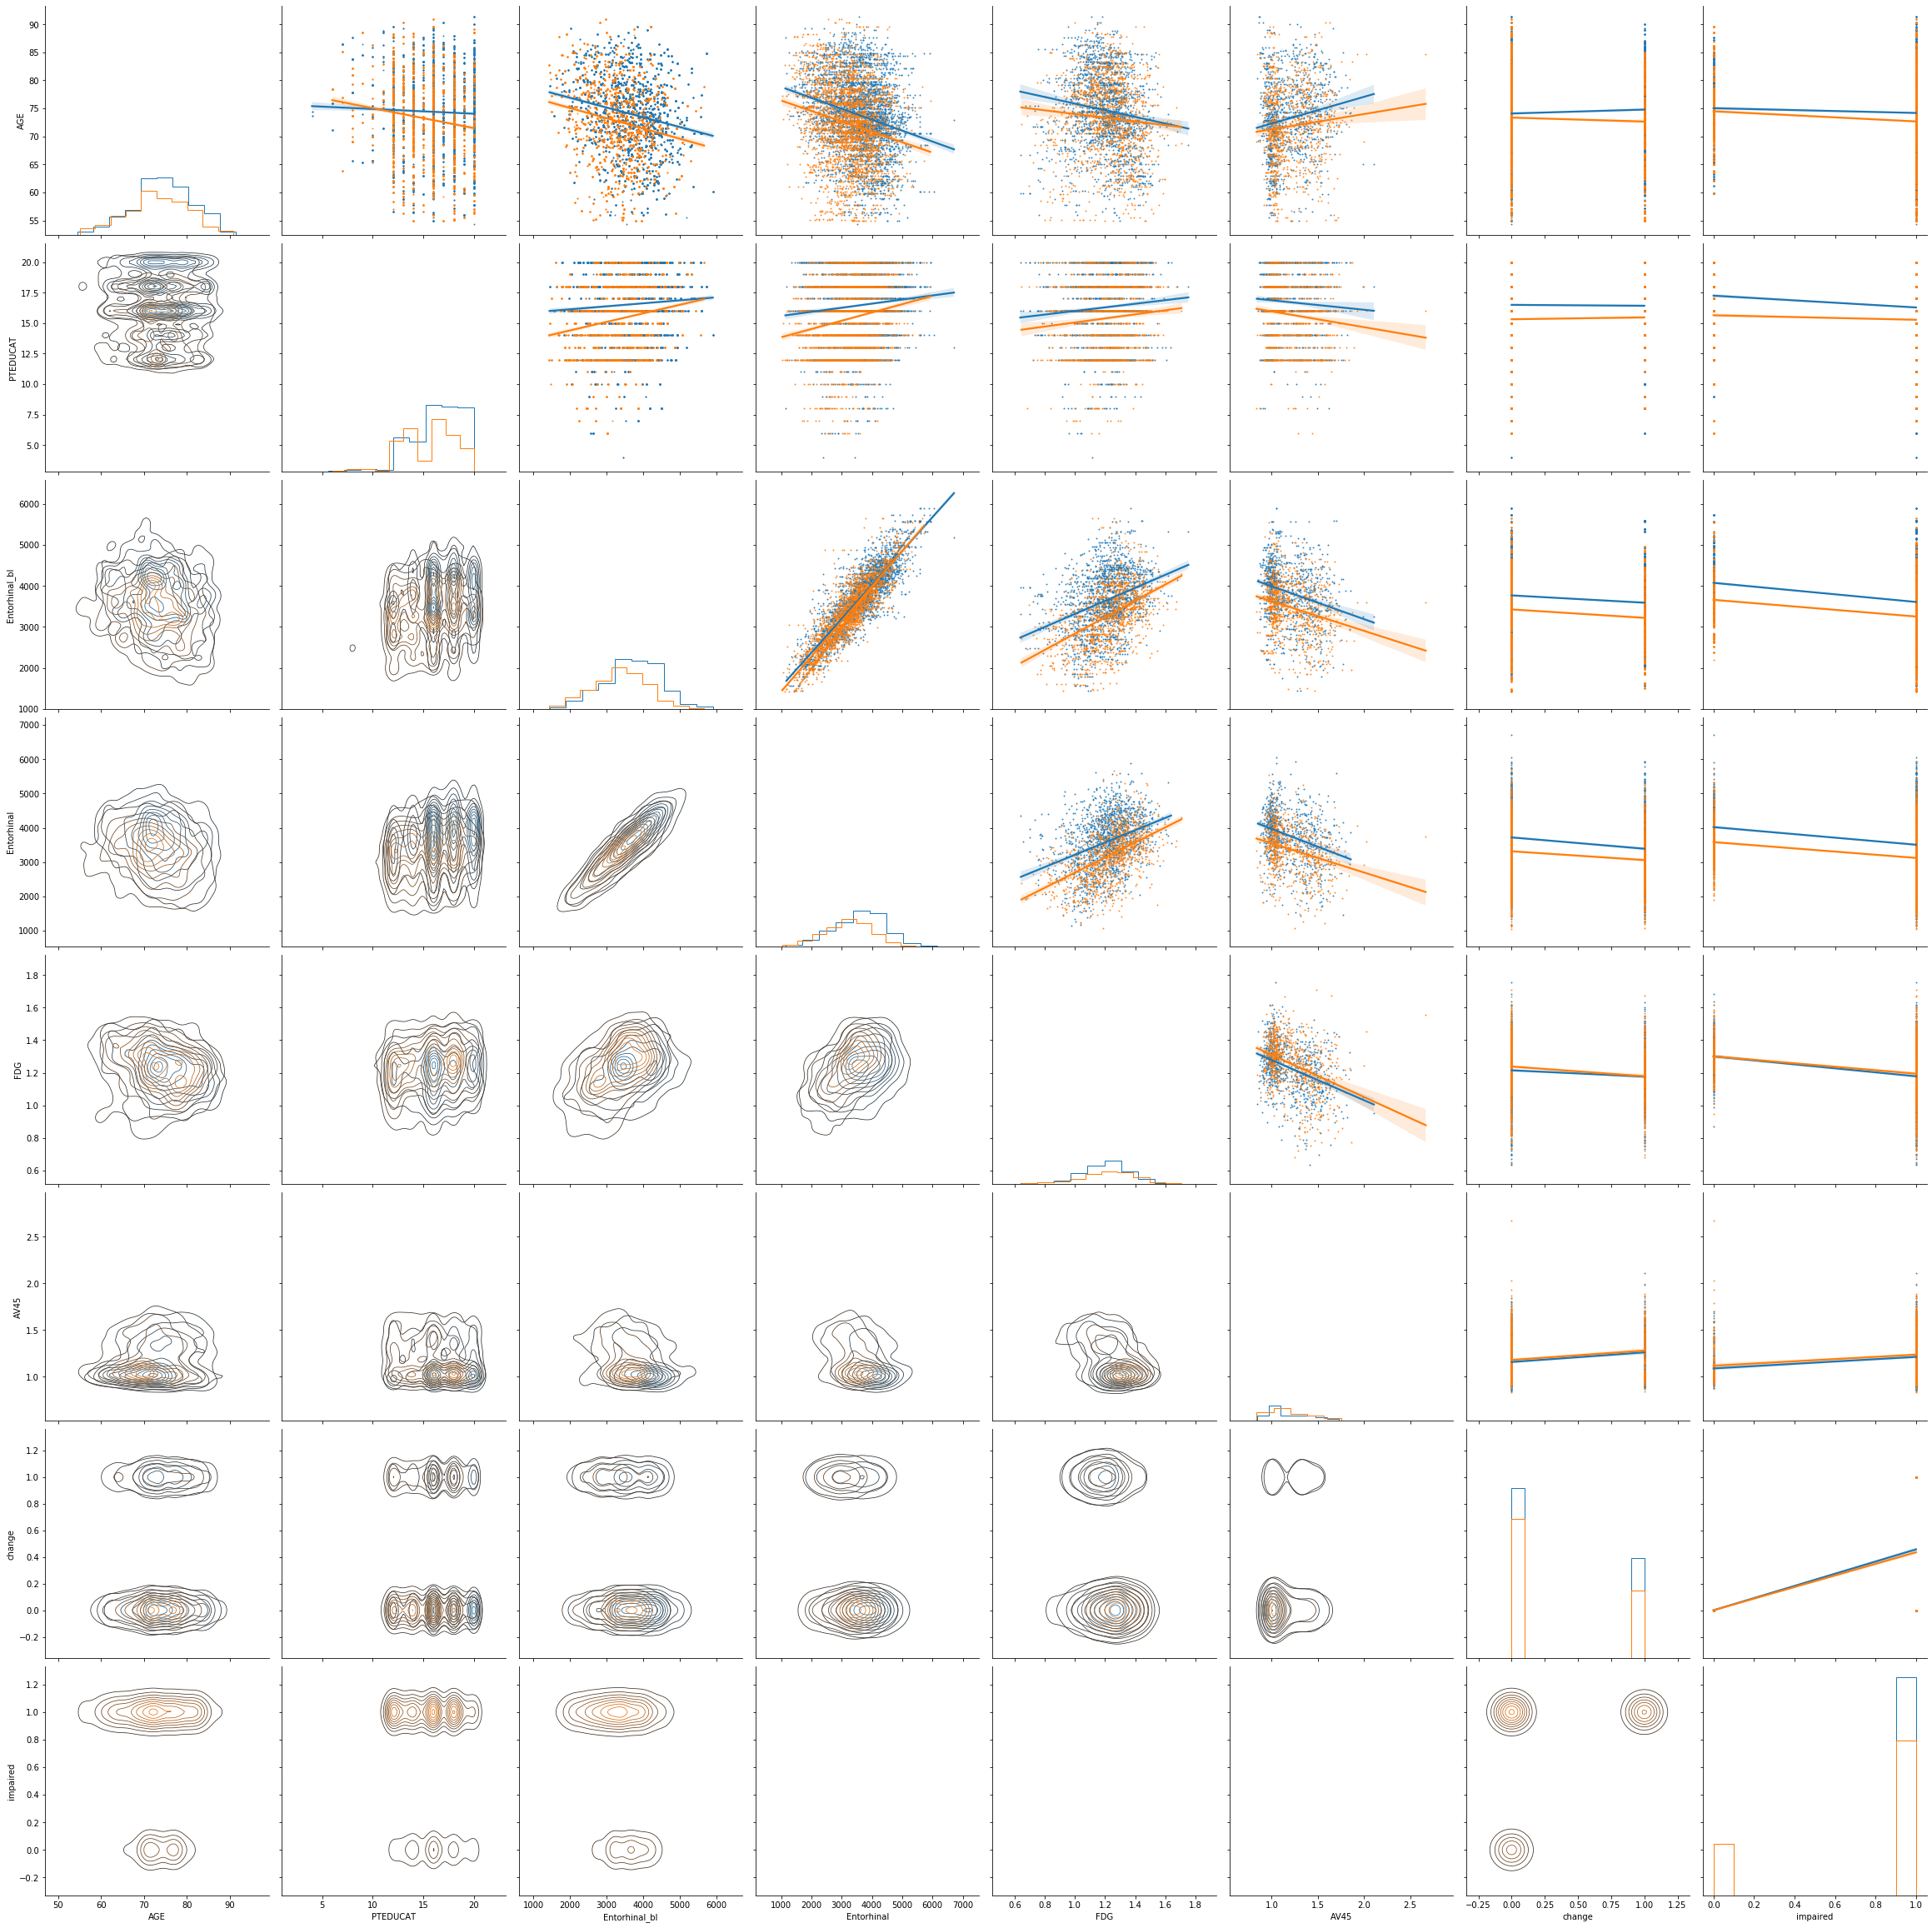

In [54]:
hueby = 'PTGENDER'
g = sns.PairGrid(raw_data.iloc[:,plot_col], hue = hueby, height=4)
g = g.map_upper(sns.regplot, scatter_kws={"s": 1})

g = g.map_lower(sns.kdeplot, linewidths =0.75)

g = g.map_diag(plt.hist, histtype="step", linewidth=1)
print(raw_data[hueby].value_counts())
g_fig = g.fig
filename = hueby + '_big_MCI_plot.png'
g_fig.savefig(filename)

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

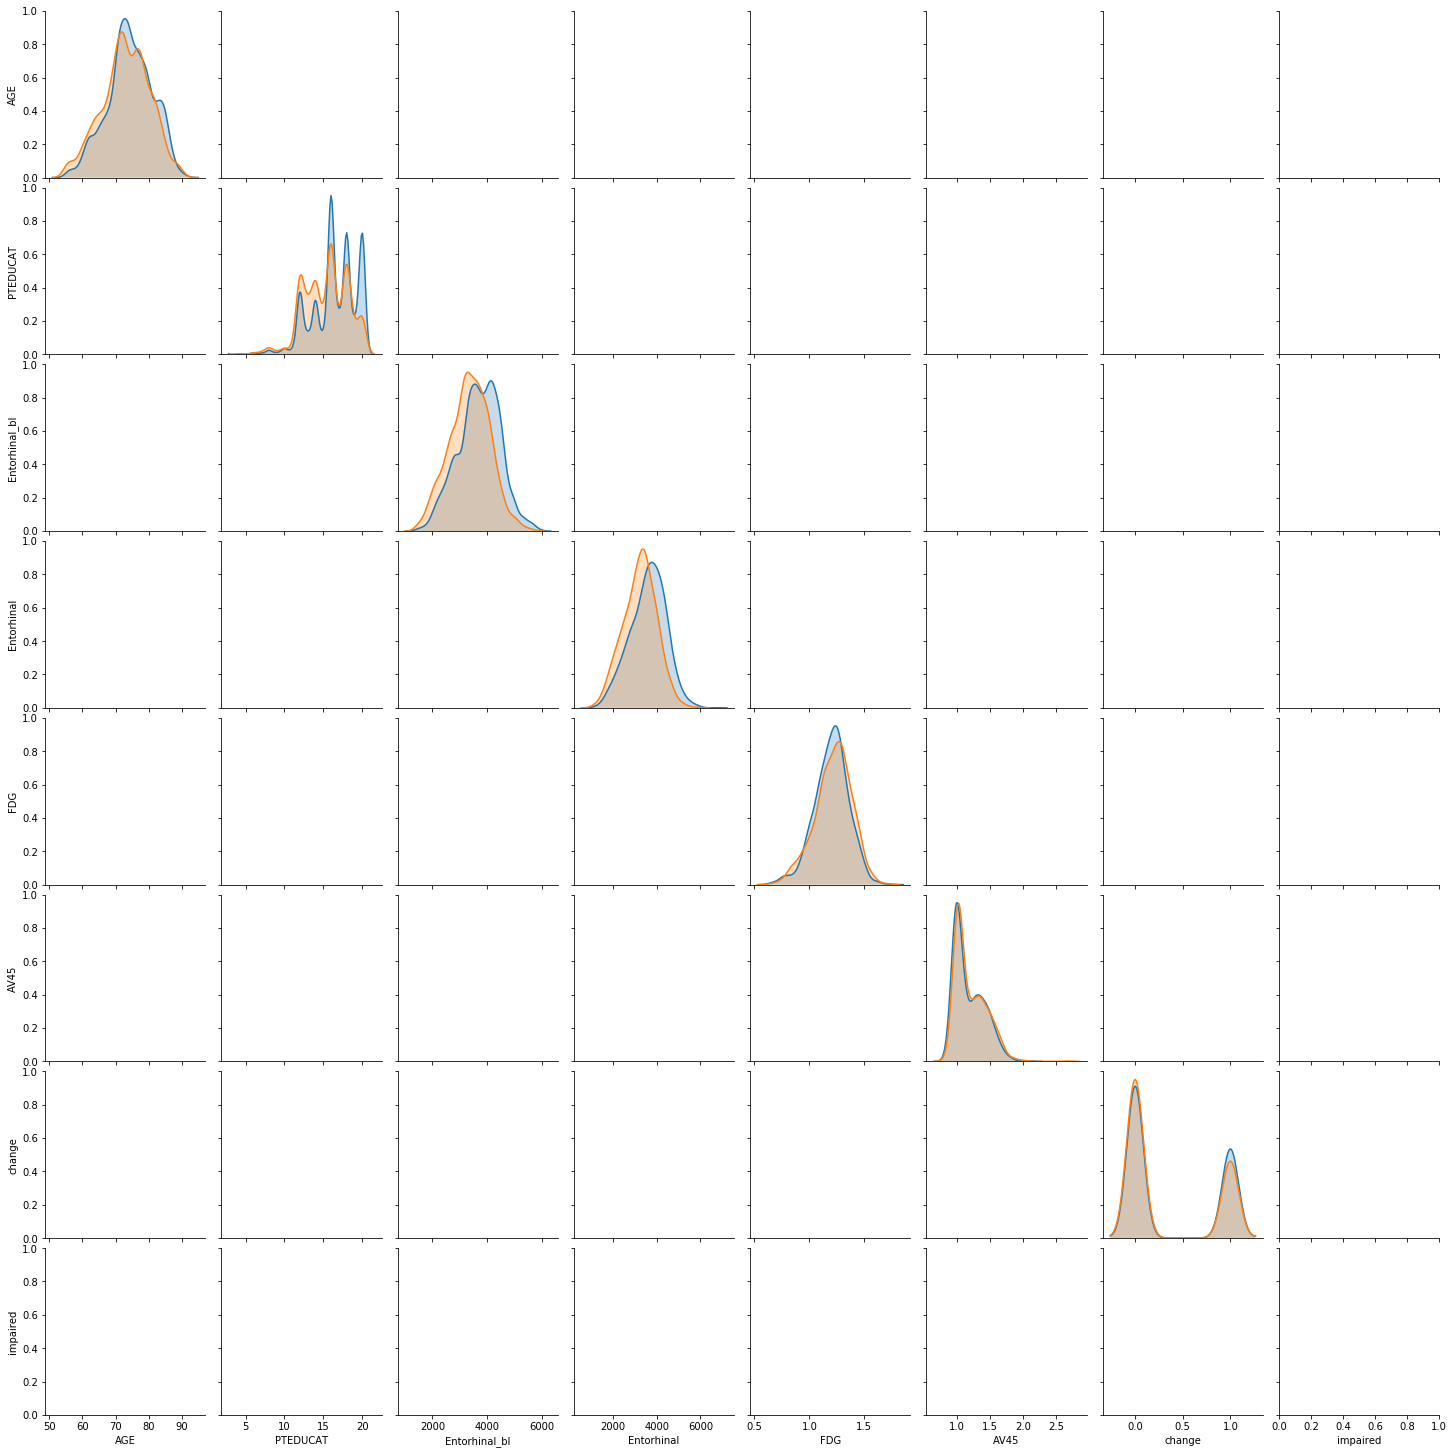

In [56]:
gender_plot = sns.pairplot(raw_data.iloc[:,plot_col], hue = 'PTGENDER', diag_kind = 'auto')

There may be a slight difference in years of education between male and female and also a slightly larger hipocampus size. Hippocampus size is likely due to overal size difference in genders, need to check if hipocampus size is absolute size or relative size. (And if there is typically a gender difference in hipocampus  relative size.)
Education need to perform a t test to see if the difference is statistically significan't and then keep in mind if it need to be corrected for in assessing male-female differences. Also there is a slight increase in the proportion of stable MCI compared to stable normal males in the dataset compared to female(DXCHANGE).

how about race and cognitive outcome?

In [ ]:
race_plot = sns.pairplot(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33]], hue = 'PTRACCAT', diag_kind='hist')
print(raw_data.PTRACCAT.value_counts())

Hard to say if there is much of a race effect. White is skewing the numbers very hard.
how about ethnicity?

In [ ]:
eth_plot = sns.pairplot(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33]], hue = 'PTETHCAT', diag_kind='auto')
print(raw_data.PTETHCAT.value_counts())

again no clear differece between latino/non-latino, possibly this catagory should be combined with race.
what about marital status?

In [ ]:
marital_plot = sns.pairplot(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33]], hue = 'PTMARRY', diag_kind='hist')
print(raw_data.PTMARRY.value_counts())

unknown marital status tend to be younger while widowed tend to be older, no difference wrt age between married, never married and divorced.
posible increased ABETA in divorced/never married/unknown v's married/widowed neeeds further investigation.

In [ ]:
diag_bl_plot = sns.pairplot(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33]], hue = 'DX_BL', diag_kind='hist')

In [ ]:
'''
diag_plot = sns.pairplot(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33]], hue = 'DX', diag_kind='auto')

g = sns.PairGrid(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33]], hue = 'PTMARRY')
'''
hueby = 'DX_bl'
g = sns.PairGrid(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33]], hue = hueby, height=4)
g = g.map_upper(sns.regplot, scatter_kws={"s": 1})

#g = g.map_lower(sns.kdeplot, linewidths =0.75)

g = g.map_diag(plt.hist, histtype="step", linewidth=1)
print(raw_data.DX_bl.value_counts())
g_fig = g.fig
filename = hueby + '_big_MCI_plot.png'
g_fig.savefig(filename)

1=Stable:NL to NL, 2=Stable:MCI to MCI, 3=Stable:AD to AD, 4=Conv:NL to MCI, 
5=Conv:MCI to AD, 6=Conv:NL to AD, 7=Rev:MCI to NL, 8=Rev:AD to MCI, 

In [ ]:

for c, v in enumerate(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33]].columns):
    print('c:', c, ' v:', v)
    hueby = v
    g = sns.PairGrid(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33]], hue = hueby, height=4)
    g = g.map_upper(sns.regplot, scatter_kws={"s": 1})

    #g = g.map_lower(sns.kdeplot, linewidths =0.75)
 
    g = g.map_diag(plt.hist, histtype="step", linewidth=1)

    g_fig = g.fig
    filename = hueby + '_big_MCI_plot.png'
    g_fig.savefig(filename)

1=Stable:NL to NL, 2=Stable:MCI to MCI, 3=Stable:AD to AD, 4=Conv:NL to MCI, 
5=Conv:MCI to AD, 6=Conv:NL to AD, 7=Rev:MCI to NL, 8=Rev:AD to MCI, 

2.0    3924
1.0    2665
3.0    1731
5.0     372
4.0     108
7.0      77
8.0      12
6.0       3
Name: DXCHANGE, dtype: int64


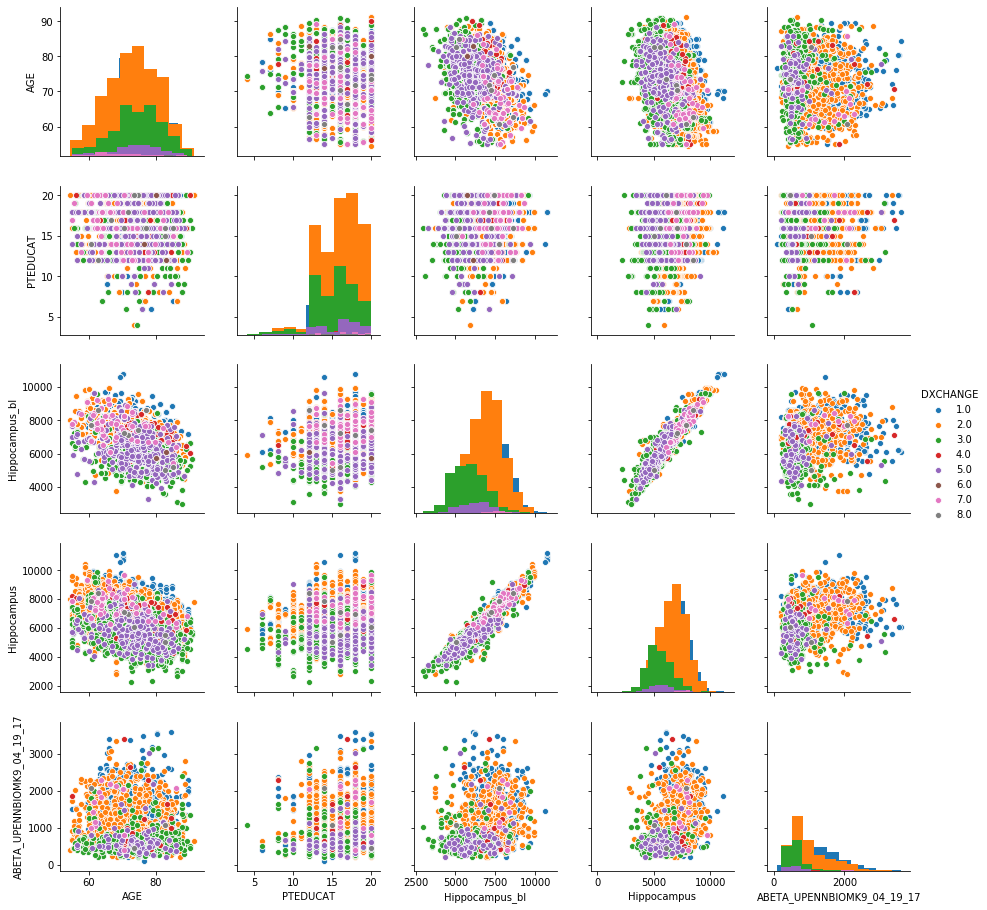

In [57]:
print(raw_data.DXCHANGE.value_counts())
diag_change_plot = sns.pairplot(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33]], hue = 'DXCHANGE', diag_kind='hist')

3 and 5 tend to have lower hipocampus size (stable AD and MCI converting to AD respectively).
Sudden conversion from normal to AD (6) apears to happen later in life.

0.0    8268
1.0    4473
Name: change, dtype: int64


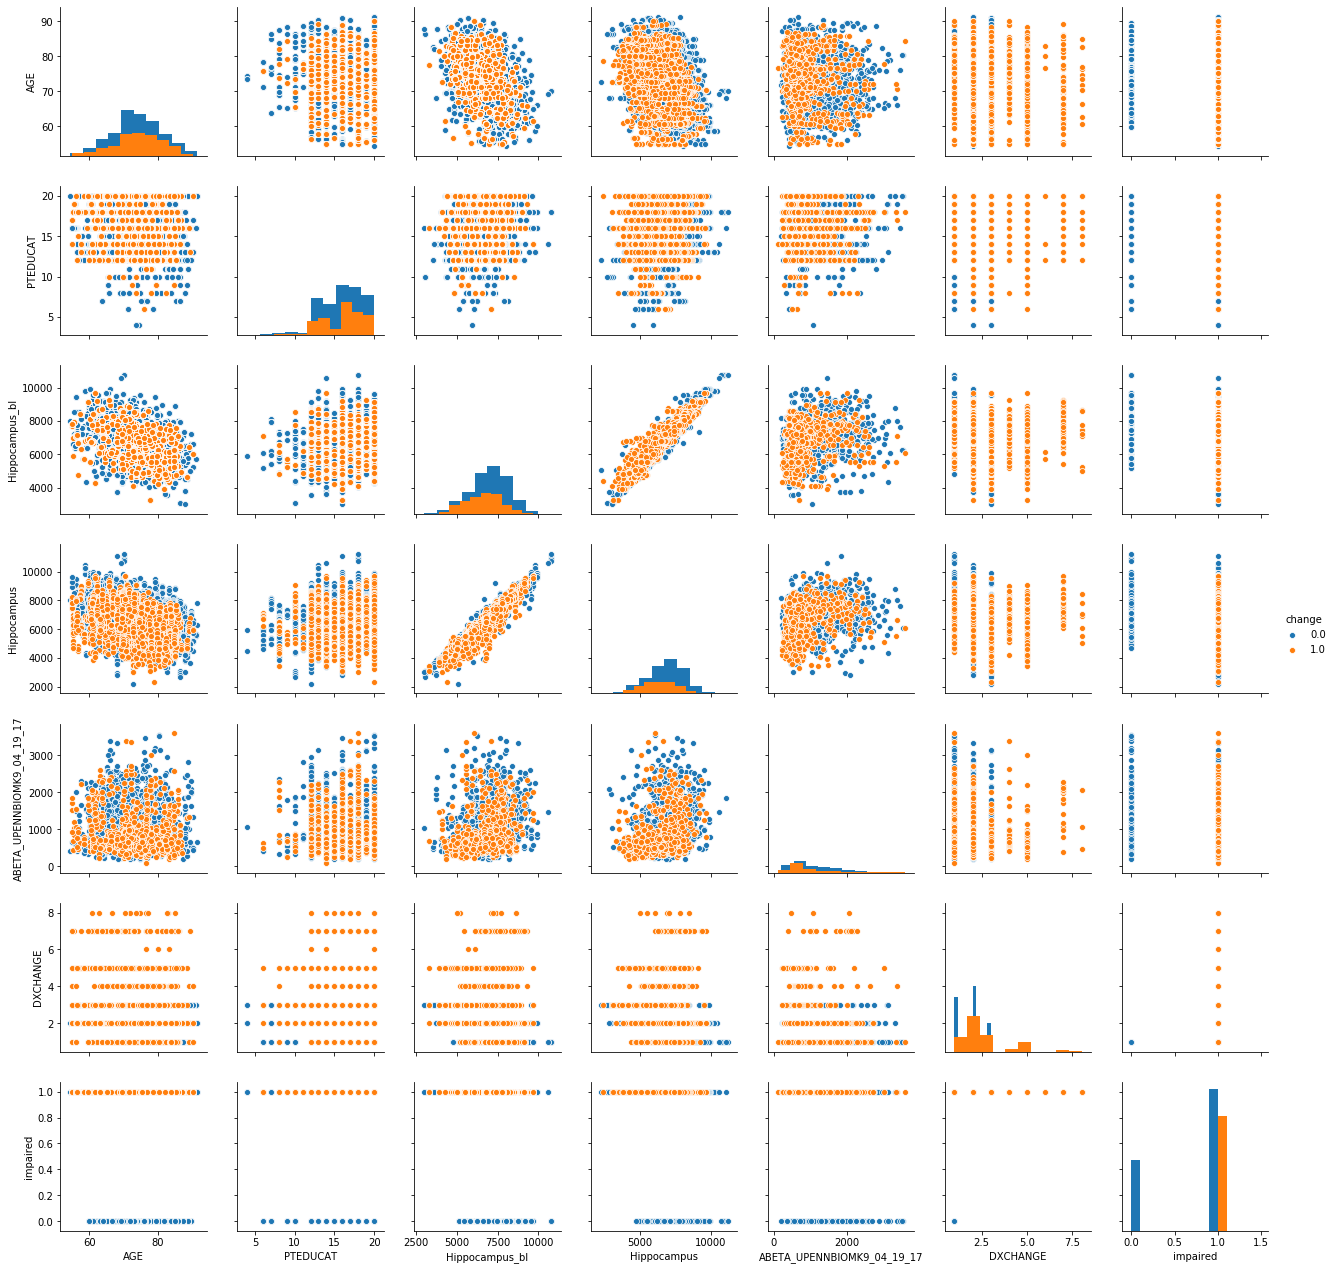

In [60]:
print(raw_data.change.value_counts())
diag_change_plot = sns.pairplot(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33,47,48]], hue = 'change', diag_kind='hist')

1.0    9977
0.0    2764
Name: impaired, dtype: int64


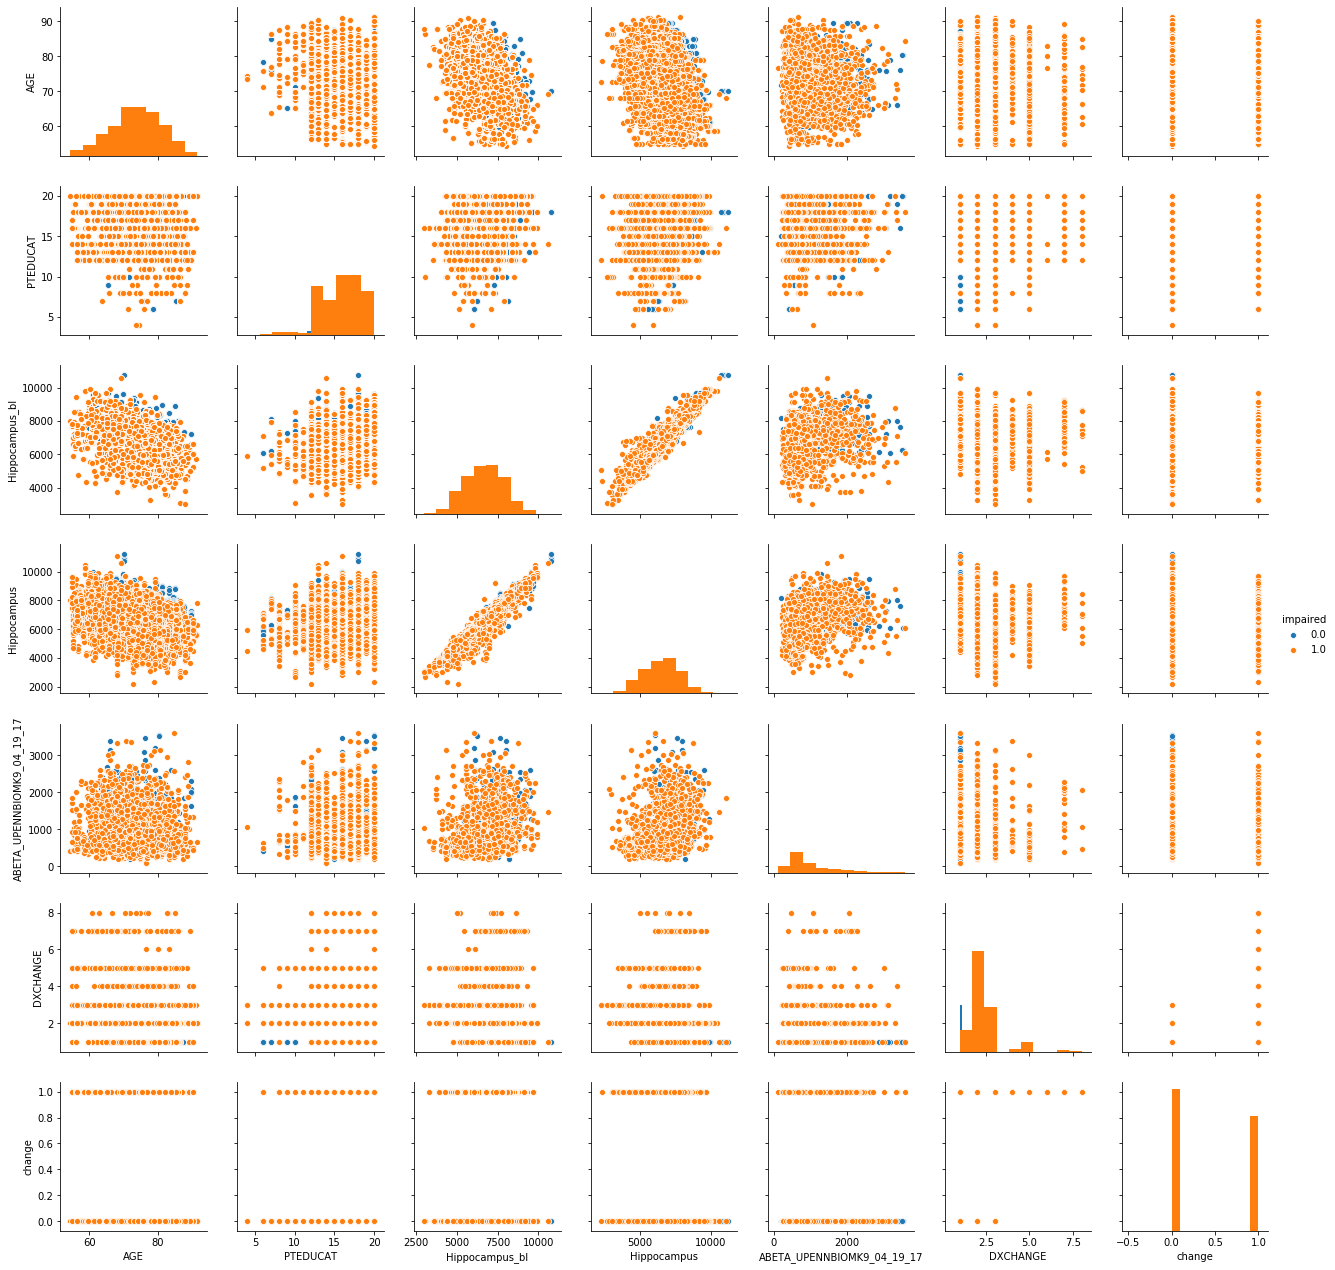

In [59]:
print(raw_data.impaired.value_counts())
diag_change_plot = sns.pairplot(raw_data.iloc[:,[4,5,6,7,8,9,22,37,43, 3,32,33,47,48]], hue = 'impaired', diag_kind='hist')